In [1]:
import pandas as pd 

df = pd.read_csv('data/training_text.csv')


In [2]:
df['severity_level'].value_counts()

severity_level
Minimal Care/Recovery at Home     9508
Moderate Care/Support Required    2723
Severe Outcome                     546
Name: count, dtype: int64

In [3]:
df[['Chief Complaint', 'Major Surgical or Invasive Procedure', 'History of Present Illness', 'Past Medical History', 'Social History', 'Physical Exam', 'Brief Hospital Course', 'Medications on Admission']] = df[
    ['Chief Complaint', 'Major Surgical or Invasive Procedure', 'History of Present Illness', 'Past Medical History', 'Social History', 'Physical Exam', 'Brief Hospital Course', 'Medications on Admission']
].fillna('')

# Concatenate the text columns
df['notes'] = df[
    ['Chief Complaint', 'Major Surgical or Invasive Procedure', 'History of Present Illness', 'Past Medical History', 'Social History', 'Physical Exam', 'Brief Hospital Course', 'Medications on Admission']
].apply(lambda x: ' '.join(x), axis=1)

df = df[['notes', 'severity_level']]

In [4]:
from sklearn.preprocessing import LabelEncoder

# Encode the labels
le = LabelEncoder()
df['severity_level'] = le.fit_transform(df['severity_level'])


In [20]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 4.2 MB/s eta 0:00:00a 0:00:01


In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['notes'], df['severity_level'], test_size=0.2, random_state=42
)


# Tokenize the text data using a tokenizer
from transformers import LongformerTokenizer

tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding=True, max_length=4096)

# Tokenize the training and testing data
train_encodings = tokenize_function(list(X_train))
test_encodings = tokenize_function(list(X_test))

# Create a PyTorch dataset class
import torch


class ClinicalNotesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels if isinstance(labels, torch.Tensor) else torch.tensor(labels.values, dtype=torch.long)
        self.indices = list(range(len(self.labels)))  # Ensure we have a list of indices

    def __getitem__(self, idx):
        idx = self.indices[idx]  # Access using positional index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Handle imbalanced data using SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(train_encodings['input_ids'], y_train)

# Convert resampled data back to appropriate format
train_encodings_resampled = {'input_ids': X_resampled}
train_dataset = ClinicalNotesDataset(train_encodings_resampled, y_resampled)
test_dataset = ClinicalNotesDataset(test_encodings, y_test)


In [6]:
import torch

# Save the datasets to local directory
torch.save(train_dataset, 'train_dataset1.pt')
torch.save(test_dataset, 'test_dataset1.pt')


Original distribution: Counter({0: 7592, 1: 2188, 2: 441})
Resampled distribution: Counter({0: 7592, 2: 7592, 1: 7592})


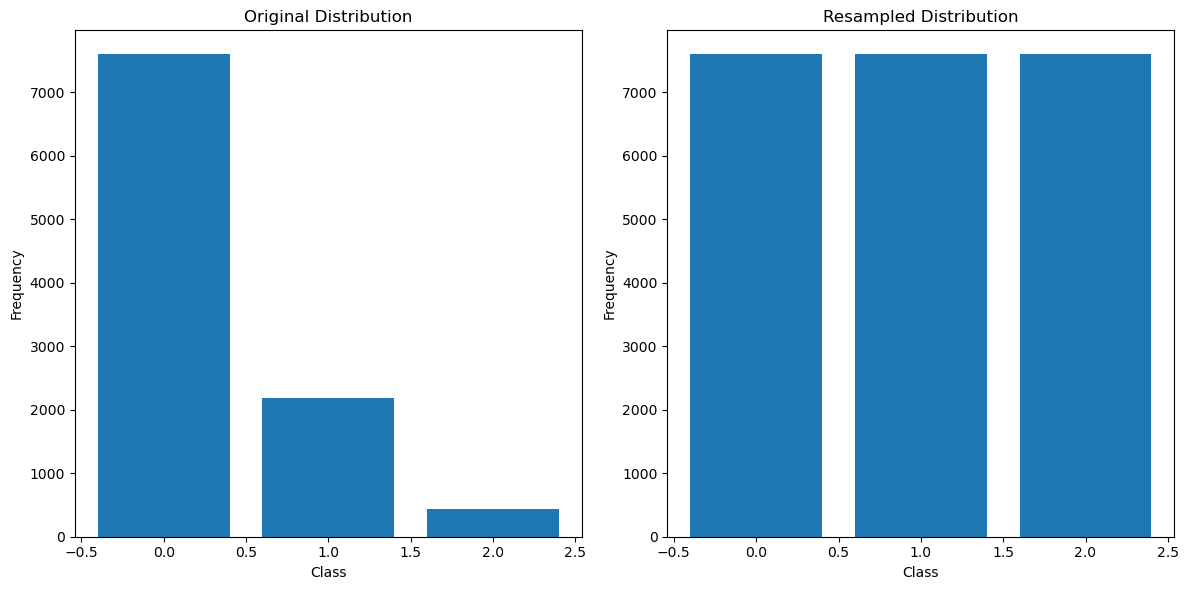

In [23]:
from collections import Counter
import matplotlib.pyplot as plt

# Inspect the distribution of the original y_train
original_distribution = Counter(y_train)
print("Original distribution:", original_distribution)

# Inspect the distribution of the resampled y_resampled
resampled_distribution = Counter(y_resampled)
print("Resampled distribution:", resampled_distribution)

# Plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot original distribution
axes[0].bar(original_distribution.keys(), original_distribution.values())
axes[0].set_title("Original Distribution")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Frequency")

# Plot resampled distribution
axes[1].bar(resampled_distribution.keys(), resampled_distribution.values())
axes[1].set_title("Resampled Distribution")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [25]:
import torch
from transformers import LongformerForSequenceClassification, Trainer, TrainingArguments

# Check if MPS is available and set the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print('device', device)
# Load the model
model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=3)
model.to(device)

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
          

In [29]:
from transformers import LongformerForSequenceClassification, Trainer, TrainingArguments

# Set up training arguments with gradient accumulation
training_args = TrainingArguments(
    output_dir='./long_results',
    num_train_epochs=3,
    per_device_train_batch_size=1,  # Reduce batch size
    per_device_eval_batch_size=1,   # Reduce batch size
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)


# Define a custom Trainer to move batches to MPS
class CustomTrainer(Trainer):
    def training_step(self, model, inputs):
        inputs = self._prepare_inputs(inputs)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        return super().training_step(model, inputs)

    def evaluation_loop(self, dataloader, description, prediction_loss_only=None, ignore_keys=None, metric_key_prefix="eval"):
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
        return super().evaluation_loop(dataloader, description, prediction_loss_only, ignore_keys, metric_key_prefix)

# Initialize Custom Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()
predictions = trainer.predict(test_dataset)
preds = torch.argmax(predictions.predictions, axis=1)

# Calculate evaluation metrics
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds, target_names=le.classes_))


  0%|          | 0/68328 [00:00<?, ?it/s]

{'loss': 1.116, 'grad_norm': 28.996734619140625, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0}
{'loss': 1.0853, 'grad_norm': 9.19951343536377, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.0}
{'loss': 1.1018, 'grad_norm': 75.77980041503906, 'learning_rate': 3e-06, 'epoch': 0.0}
{'loss': 1.0783, 'grad_norm': 14.065328598022461, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.0}
{'loss': 1.0589, 'grad_norm': 9.704092025756836, 'learning_rate': 5e-06, 'epoch': 0.0}
{'loss': 0.9795, 'grad_norm': 15.422040939331055, 'learning_rate': 6e-06, 'epoch': 0.0}
{'loss': 1.1482, 'grad_norm': 9.09756088256836, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.0}
{'loss': 0.9805, 'grad_norm': 11.774179458618164, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.0}
{'loss': 0.9221, 'grad_norm': 12.46634292602539, 'learning_rate': 9e-06, 'epoch': 0.0}
{'loss': 0.9599, 'grad_norm': 29.690549850463867, 'learning_rate': 1e-05, 'epoch': 0.0}
{'loss': 0.9029, 'grad_norm': 10.5313596725463

KeyboardInterrupt: 